In [1]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import sys
sys.path.append("/Users/yufanxia/Documents/GitHub")
from perturbgene.data_utils import GeneTokenizer, read_h5ad_file
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from scipy import stats
import itertools

/Users/yufanxia/Documents/GitHub/perturbgene/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("/Users/yufanxia/Downloads/chunk3562_processed.h5ad")
adata

/Users/yufanxia/Documents/GitHub/perturbgene/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10000 × 58604
    obs: 'soma_joinid_column', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', 'ZBED1_embedding_status', 'TRAF5_embedding_status', 'GSK3A_embedding_status', 'FBXL19_embedding_status', 'RBX1_embedding_status', 'FBXO7_embedding_status', 'CUL1_embedding_status', 'PINK1_embedding_status', 'PARK7_embedding_status', 'GIGYF2_embedding_status', 'ATP13A2_embedding_status', 'PRKN_embedding_status', 'PLA2G6_embedding_status', 'SKP1_embedding_status', 'LONP2_embedding_status', 'CNTNAP2_embe

In [3]:
age_embeddings = adata.obsm['development_stage_embeddings']

# Initialize a list to store the cosine similarity values for each gene
cosine_similarities = {}

# Loop through each gene embedding in obsm
for gene_key in adata.obsm.keys():
    if '_embeddings' in gene_key and gene_key not in ['development_stage_embeddings', 'tissue_embeddings', "cell_type_embeddings"]:
        gene_name = gene_key.replace('_embeddings', '')  # Get the actual gene name

        # Get the gene embeddings
        gene_embeddings = adata.obsm[gene_key]
        
        # Filter valid cells by checking the corresponding status in adata.obs
        valid_mask = (adata.obs[f'{gene_name}_embedding_status'] == 'present') & (adata.obs["disease"] == "normal")
        
        # Select only valid gene embeddings and corresponding age embeddings
        valid_gene_embeddings = gene_embeddings[valid_mask]
        valid_age_embeddings = age_embeddings[valid_mask]

        if len(valid_gene_embeddings) != 0:
        
            # Compute cosine similarity for valid cells
            cosine_sim = cosine_similarity(valid_gene_embeddings, valid_age_embeddings)
            
            # Take the diagonal since we are comparing cell i's gene embedding to cell i's age embedding
            diagonal_cosine_sim = np.diag(cosine_sim)
            
            # Store the mean cosine similarity for this gene
            cosine_similarities[gene_name] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

for gene, (values, mean, length) in cosine_similarities.items():
    print(f"Mean Cosine Similarity of {gene} is {mean}")

Mean Cosine Similarity of ADAM12 is 0.31654801964759827
Mean Cosine Similarity of ADAMDEC1 is 0.2933143079280853
Mean Cosine Similarity of ALB is 0.27780672907829285
Mean Cosine Similarity of ALDH3A1 is 0.21253395080566406
Mean Cosine Similarity of APOA1 is 0.2743653953075409
Mean Cosine Similarity of APOA4 is 0.11837483942508698
Mean Cosine Similarity of APOC3 is 0.1538918912410736
Mean Cosine Similarity of ARHGAP21 is 0.27856874465942383
Mean Cosine Similarity of ATP13A2 is 0.37466686964035034
Mean Cosine Similarity of BPIFA1 is 0.11144820600748062
Mean Cosine Similarity of BPIFB1 is 0.16038307547569275
Mean Cosine Similarity of CACYBP is 0.28749391436576843
Mean Cosine Similarity of CAMTA1 is 0.2467610239982605
Mean Cosine Similarity of CCK is 0.32088321447372437
Mean Cosine Similarity of CCL19 is 0.26377207040786743
Mean Cosine Similarity of CCL21 is 0.31503966450691223
Mean Cosine Similarity of CCL3 is 0.23895566165447235
Mean Cosine Similarity of CD74 is 0.24415461719036102
Mean 

In [6]:
filtered_dict = {k: v for k, v in cosine_similarities.items() if v[2] > 50}
sorted_dict = sorted(filtered_dict.items(), key=lambda x: x[1][1], reverse=True)
top_10_items = sorted_dict[:10]
for gene, (values, mean, length) in top_10_items:
    print(f"Mean Cosine Similarity of {gene} is {mean}")

Mean Cosine Similarity of ATP13A2 is 0.37466686964035034
Mean Cosine Similarity of FBXL19 is 0.3613166245762408
Mean Cosine Similarity of TRAF5 is 0.35303185725376035
Mean Cosine Similarity of PINK1 is 0.35140514373779297
Mean Cosine Similarity of IGDCC3 is 0.34847724437713623
Mean Cosine Similarity of FOXJ3 is 0.3482804000377655
Mean Cosine Similarity of CUL1 is 0.3400783836841583
Mean Cosine Similarity of GSK3A is 0.3383993336978343
Mean Cosine Similarity of FBXO7 is 0.3313876986503601
Mean Cosine Similarity of COA1 is 0.32879871129989624


/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2446/2249575070.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')


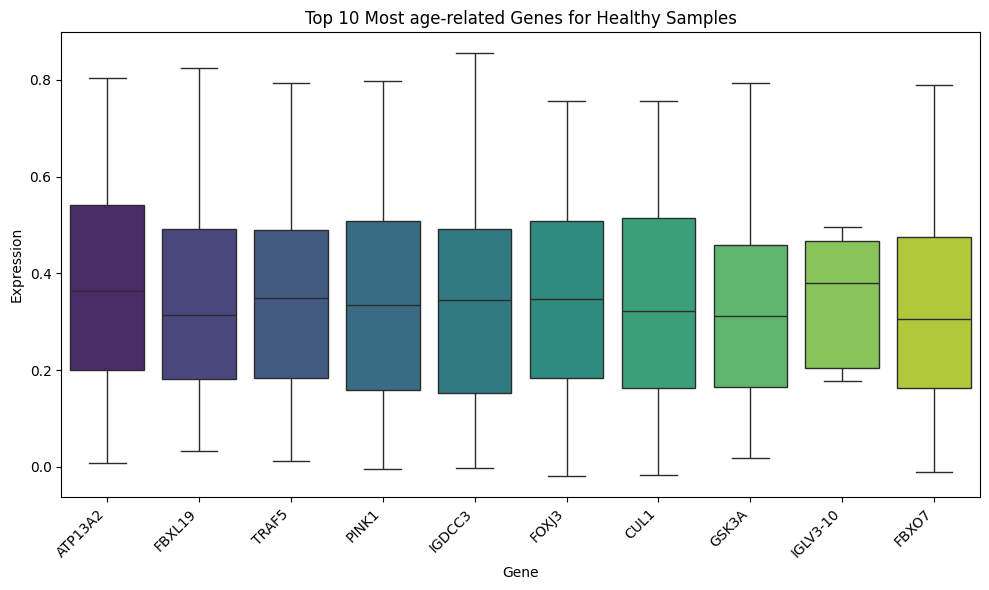

In [4]:
sorted_genes = sorted(cosine_similarities.items(), key=lambda x: x[1][1], reverse=True)[:10]
        
# Extract the values for the top 10 genes
gene_names = [gene for gene, _ in sorted_genes]
values = [cosine_similarities[gene][0] for gene, _ in sorted_genes]  # List of lists (each gene's values)

# Prepare the data for the boxplot
boxplot_data = []
for gene_name, gene_values in zip(gene_names, values):
    for value in gene_values:
        boxplot_data.append({'Gene': gene_name, 'Expression': value})

# Convert to DataFrame for Seaborn plotting
import pandas as pd
df = pd.DataFrame(boxplot_data)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')

plt.title(f'Top 10 Most age-related Genes for Healthy Samples')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2777/2249575070.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')


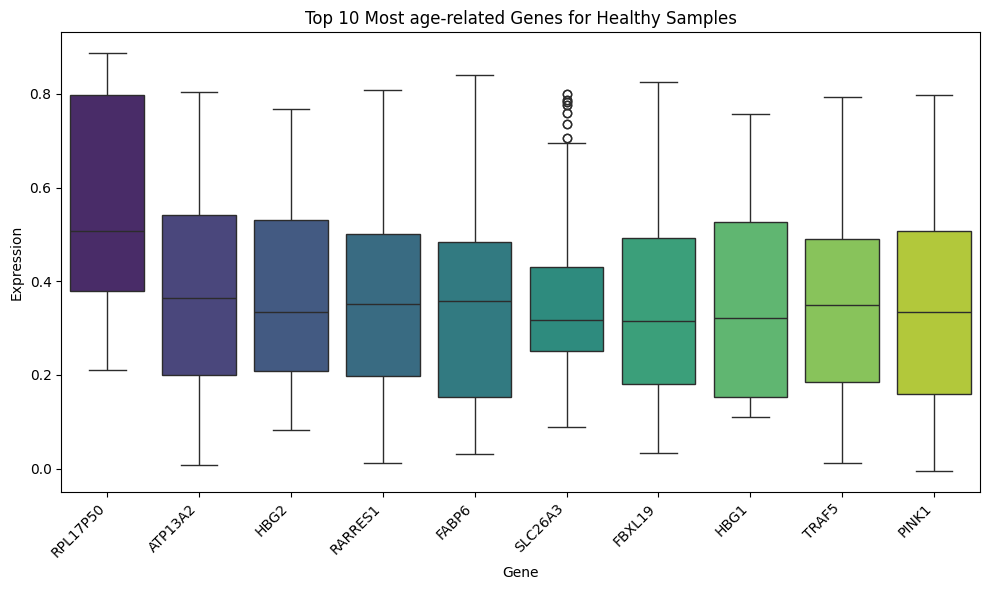

In [4]:
sorted_genes = sorted(cosine_similarities.items(), key=lambda x: x[1][1], reverse=True)[:10]
        
# Extract the values for the top 10 genes
gene_names = [gene for gene, _ in sorted_genes]
values = [cosine_similarities[gene][0] for gene, _ in sorted_genes]  # List of lists (each gene's values)

# Prepare the data for the boxplot
boxplot_data = []
for gene_name, gene_values in zip(gene_names, values):
    for value in gene_values:
        boxplot_data.append({'Gene': gene_name, 'Expression': value})

# Convert to DataFrame for Seaborn plotting
import pandas as pd
df = pd.DataFrame(boxplot_data)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')

plt.title(f'Top 10 Most age-related Genes for Healthy Samples')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

Mean Cosine Similarity of ARHGAP21 is 0.222793847322464
Mean Cosine Similarity of ATP13A2 is 0.2826474606990814
Mean Cosine Similarity of CACYBP is 0.20871326327323914
Mean Cosine Similarity of CAMTA1 is 0.2049945890903473
Mean Cosine Similarity of CDKAL1 is 0.24280278384685516
Mean Cosine Similarity of CNTN1 is 0.16279584169387817
Mean Cosine Similarity of CNTN5 is 0.1733604073524475
Mean Cosine Similarity of CNTNAP2 is 0.16322997212409973
Mean Cosine Similarity of COA1 is 0.25641170144081116
Mean Cosine Similarity of COX7A2 is 0.21981117129325867
Mean Cosine Similarity of CUL1 is 0.2663722336292267
Mean Cosine Similarity of EXOC4 is 0.209478959441185
Mean Cosine Similarity of FBXL19 is 0.30739412919424763
Mean Cosine Similarity of FBXO7 is 0.22224624454975128
Mean Cosine Similarity of FOXJ3 is 0.264695405960083
Mean Cosine Similarity of GIGYF2 is 0.2601085603237152
Mean Cosine Similarity of GSK3A is 0.21950324571234775
Mean Cosine Similarity of HIVEP2 is 0.23096230626106262
Mean Cosi

/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2528/1444224479.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')


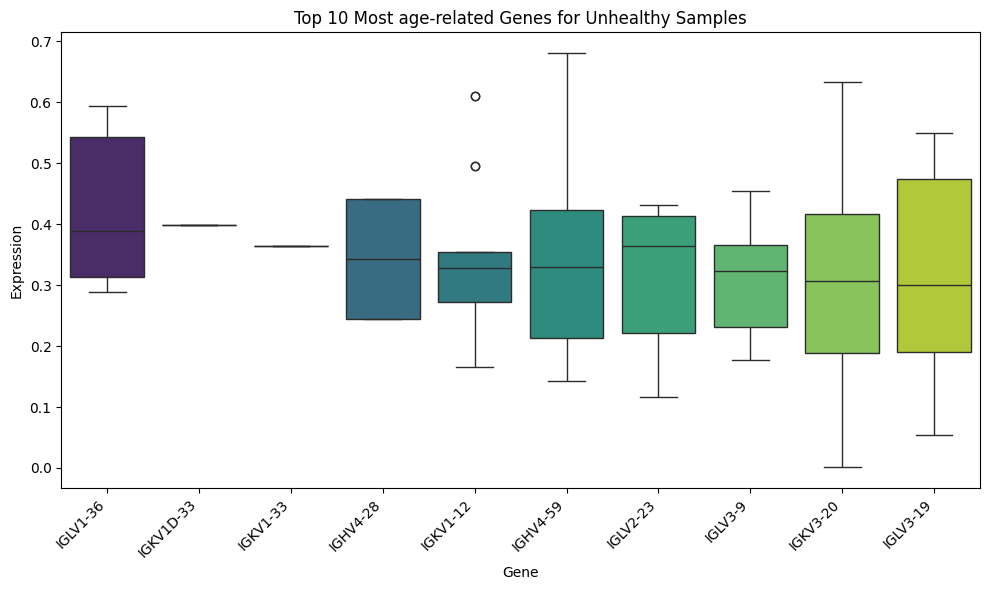

In [3]:
age_embeddings = adata.obsm['development_stage_embeddings']

# Initialize a list to store the cosine similarity values for each gene
cosine_similarities = {}

# Loop through each gene embedding in obsm
for gene_key in adata.obsm.keys():
    if '_embeddings' in gene_key and gene_key not in ['development_stage_embeddings', 'tissue_embeddings', "cell_type_embeddings"]:
        gene_name = gene_key.replace('_embeddings', '')  # Get the actual gene name

        # Get the gene embeddings
        gene_embeddings = adata.obsm[gene_key]
        
        # Filter valid cells by checking the corresponding status in adata.obs
        valid_mask = (adata.obs[f'{gene_name}_embedding_status'] == 'present') & (adata.obs["disease"] != "normal")
        
        # Select only valid gene embeddings and corresponding age embeddings
        valid_gene_embeddings = gene_embeddings[valid_mask]
        valid_age_embeddings = age_embeddings[valid_mask]

        if len(valid_gene_embeddings) != 0:
        
            # Compute cosine similarity for valid cells
            cosine_sim = cosine_similarity(valid_gene_embeddings, valid_age_embeddings)
            
            # Take the diagonal since we are comparing cell i's gene embedding to cell i's age embedding
            diagonal_cosine_sim = np.diag(cosine_sim)
            
            # Store the mean cosine similarity for this gene
            cosine_similarities[gene_name] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

for gene, (values, mean, len) in cosine_similarities.items():
    print(f"Mean Cosine Similarity of {gene} is {mean}")
sorted_genes = sorted(cosine_similarities.items(), key=lambda x: x[1][1], reverse=True)[:10]
        
# Extract the values for the top 10 genes
gene_names = [gene for gene, _ in sorted_genes]
values = [cosine_similarities[gene][0] for gene, _ in sorted_genes]  # List of lists (each gene's values)

# Prepare the data for the boxplot
boxplot_data = []
for gene_name, gene_values in zip(gene_names, values):
    for value in gene_values:
        boxplot_data.append({'Gene': gene_name, 'Expression': value})

# Convert to DataFrame for Seaborn plotting
import pandas as pd
df = pd.DataFrame(boxplot_data)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')

plt.title(f'Top 10 Most age-related Genes for Unhealthy Samples')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

Mean Cosine Similarity of ADAM12 is 0.22333785891532898
Mean Cosine Similarity of ADAMDEC1 is 0.28028327226638794
Mean Cosine Similarity of ALB is 0.35136646032333374
Mean Cosine Similarity of ALDH3A1 is 0.22388644516468048
Mean Cosine Similarity of APOA1 is 0.1873658299446106
Mean Cosine Similarity of APOA4 is 0.14806465804576874
Mean Cosine Similarity of APOC3 is 0.11875539273023605
Mean Cosine Similarity of ARHGAP21 is 0.222793847322464
Mean Cosine Similarity of ATP13A2 is 0.2826474606990814
Mean Cosine Similarity of BPIFA1 is 0.16522523760795593
Mean Cosine Similarity of BPIFB1 is 0.15916061401367188
Mean Cosine Similarity of CACYBP is 0.20871326327323914
Mean Cosine Similarity of CAMTA1 is 0.2049945890903473
Mean Cosine Similarity of CCK is 0.3187682628631592
Mean Cosine Similarity of CCL19 is 0.230131134390831
Mean Cosine Similarity of CCL21 is 0.2508736550807953
Mean Cosine Similarity of CCL3 is 0.25514769554138184
Mean Cosine Similarity of CD74 is 0.22903862595558167
Mean Cosin

/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/1444224479.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')


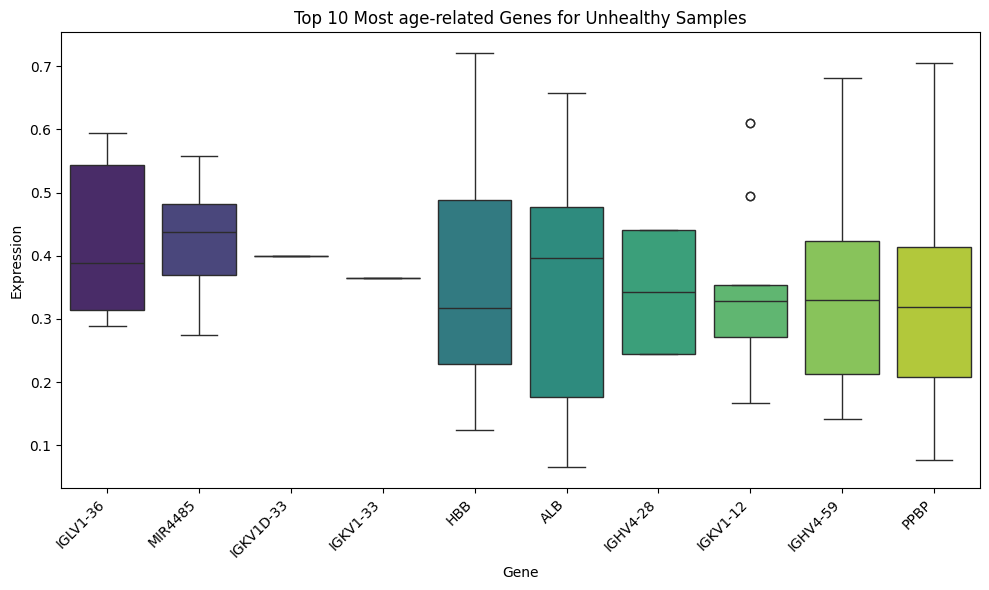

In [3]:
age_embeddings = adata.obsm['development_stage_embeddings']

# Initialize a list to store the cosine similarity values for each gene
cosine_similarities = {}

# Loop through each gene embedding in obsm
for gene_key in adata.obsm.keys():
    if '_embeddings' in gene_key and gene_key not in ['development_stage_embeddings', 'tissue_embeddings', "cell_type_embeddings"]:
        gene_name = gene_key.replace('_embeddings', '')  # Get the actual gene name

        # Get the gene embeddings
        gene_embeddings = adata.obsm[gene_key]
        
        # Filter valid cells by checking the corresponding status in adata.obs
        valid_mask = (adata.obs[f'{gene_name}_embedding_status'] == 'present') & (adata.obs["disease"] != "normal")
        
        # Select only valid gene embeddings and corresponding age embeddings
        valid_gene_embeddings = gene_embeddings[valid_mask]
        valid_age_embeddings = age_embeddings[valid_mask]

        if len(valid_gene_embeddings) != 0:
        
            # Compute cosine similarity for valid cells
            cosine_sim = cosine_similarity(valid_gene_embeddings, valid_age_embeddings)
            
            # Take the diagonal since we are comparing cell i's gene embedding to cell i's age embedding
            diagonal_cosine_sim = np.diag(cosine_sim)
            
            # Store the mean cosine similarity for this gene
            cosine_similarities[gene_name] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

for gene, (values, mean, len) in cosine_similarities.items():
    print(f"Mean Cosine Similarity of {gene} is {mean}")
sorted_genes = sorted(cosine_similarities.items(), key=lambda x: x[1][1], reverse=True)[:10]
        
# Extract the values for the top 10 genes
gene_names = [gene for gene, _ in sorted_genes]
values = [cosine_similarities[gene][0] for gene, _ in sorted_genes]  # List of lists (each gene's values)

# Prepare the data for the boxplot
boxplot_data = []
for gene_name, gene_values in zip(gene_names, values):
    for value in gene_values:
        boxplot_data.append({'Gene': gene_name, 'Expression': value})

# Convert to DataFrame for Seaborn plotting
import pandas as pd
df = pd.DataFrame(boxplot_data)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')

plt.title(f'Top 10 Most age-related Genes for Unhealthy Samples')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

### for specific cell types

In [22]:
# Initialize a dictionary to store the cosine similarity values for each gene and cell type
cosine_similarities_by_cell_type = {}

# Retrieve age embeddings from 'development_stage_embeddings'
age_embeddings = adata.obsm['development_stage_embeddings']

# Loop through each unique cell type in the dataset
for cell_type in adata.obs['cell_type'].unique():
    # Initialize a dictionary for this cell type to store cosine similarities by gene
    cosine_similarities_by_cell_type[cell_type] = {}

    # Create a mask to select only cells of this particular cell type
    cell_type_mask = (adata.obs['cell_type'] == cell_type)
    
    # Loop through each gene embedding in obsm
    for gene_key in adata.obsm.keys():
        # Check if the key is for a gene embedding, and skip other embeddings
        if '_embeddings' in gene_key and gene_key not in ['development_stage_embeddings', 'tissue_embeddings', "cell_type_embeddings"]:
            gene_name = gene_key.replace('_embeddings', '')  # Get the actual gene name

            # Get the gene embeddings
            gene_embeddings = adata.obsm[gene_key]

            # Filter valid cells by gene embedding status, disease being 'normal', and the current cell type
            valid_mask = (adata.obs[f'{gene_name}_embedding_status'] == 'present') & \
                         (adata.obs["disease"] == "normal") & cell_type_mask

            # Select only valid gene embeddings and corresponding age embeddings
            valid_gene_embeddings = gene_embeddings[valid_mask]
            valid_age_embeddings = age_embeddings[valid_mask]

            # Proceed only if there are valid cells for this gene in the current cell type
            if len(valid_gene_embeddings) != 0:
                # Compute cosine similarity between the valid gene and age embeddings
                cosine_sim = cosine_similarity(valid_gene_embeddings, valid_age_embeddings)

                # Take the diagonal since we are comparing cell i's gene embedding to cell i's age embedding
                diagonal_cosine_sim = np.diag(cosine_sim)

                # Store the mean cosine similarity and the number of valid comparisons for this gene and cell type
                cosine_similarities_by_cell_type[cell_type][gene_name] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

for cell_type, gene_similarities in cosine_similarities_by_cell_type.items():
    # Sort the genes by mean cosine similarity in descending order
    sorted_genes = sorted(gene_similarities.items(), key=lambda x: x[1][1], reverse=True)

    print(f"Top 10 Genes for Cell Type: {cell_type}")
    # Print the top 10 genes for this cell type
    for i, (gene, (values, mean_similarity, count)) in enumerate(sorted_genes[:10]):
        print(f"  {i+1}. Gene: {gene}, Mean Cosine Similarity: {mean_similarity}, Number of Cells: {count}")
    print()  # Newline for readability

Top 10 Genes for Cell Type: neuron
  1. Gene: SFTPA2, Mean Cosine Similarity: 0.7872364521026611, Number of Cells: 8
  2. Gene: SCGB1A1, Mean Cosine Similarity: 0.7318256497383118, Number of Cells: 6
  3. Gene: SAA2, Mean Cosine Similarity: 0.7073070406913757, Number of Cells: 2
  4. Gene: SUSD2, Mean Cosine Similarity: 0.7012396454811096, Number of Cells: 2
  5. Gene: HSPA6, Mean Cosine Similarity: 0.6345264911651611, Number of Cells: 2
  6. Gene: STAR, Mean Cosine Similarity: 0.6301774978637695, Number of Cells: 17
  7. Gene: RPL17P50, Mean Cosine Similarity: 0.5786188244819641, Number of Cells: 34
  8. Gene: BPIFB1, Mean Cosine Similarity: 0.5749359726905823, Number of Cells: 6
  9. Gene: FBXL19, Mean Cosine Similarity: 0.5741603278855677, Number of Cells: 116
  10. Gene: ALB, Mean Cosine Similarity: 0.5681275725364685, Number of Cells: 21

Top 10 Genes for Cell Type: classical monocyte
  1. Gene: IGLL5, Mean Cosine Similarity: 0.41943666338920593, Number of Cells: 2
  2. Gene: HBB,

In [23]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

data_dict = cosine_similarities_by_cell_type

# Directory to save plots
output_dir = 'plots/top_genes_boxplots_cell_type'
os.makedirs(output_dir, exist_ok=True)

# Plot and save the top 10 genes for each cell type
for cell_type, gene_data in data_dict.items():

    if gene_data != {}:
        # Sort the genes by their mean values and select the top 10
        sorted_genes = sorted(gene_data.items(), key=lambda x: x[1][1], reverse=True)[:10]
        
        # Extract the values for the top 10 genes
        gene_names = [gene for gene, _ in sorted_genes]
        values = [gene_data[gene][0] for gene, _ in sorted_genes]  # List of lists (each gene's values)
        
        # Prepare the data for the boxplot
        boxplot_data = []
        for gene_name, gene_values in zip(gene_names, values):
            for value in gene_values:
                boxplot_data.append({'Gene': gene_name, 'Expression': value})
        
        # Convert to DataFrame for Seaborn plotting
        import pandas as pd
        df = pd.DataFrame(boxplot_data)
        
        # Create the boxplot
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
        
        plt.title(f'Top 10 Genes for Cell Type: {cell_type}')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        
        # Save the plot
        plot_path = os.path.join(output_dir, f'{cell_type.replace("-", "_").replace("/","_")}_top10_genes_boxplot.png')
        plt.savefig(plot_path)
        plt.close()  # Close the figure after saving to avoid display


/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/2751761080.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/2751761080.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/2751761080.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
/

In [7]:
# Initialize dictionaries to store overall mean cosine similarity for each cell type
mean_cosine_by_cell_type = {}

# Loop through the cosine similarities for each cell type
for cell_type, gene_similarities in cosine_similarities_by_cell_type.items():
    # Sort the genes by mean cosine similarity in descending order
    sorted_genes = sorted(gene_similarities.items(), key=lambda x: x[1][0], reverse=True)

    # Print the top 10 genes with the highest cosine similarity for this cell type
    print(f"Top 10 Genes for Cell Type: {cell_type}")
    for i, (gene, (mean_similarity, count)) in enumerate(sorted_genes[:10]):
        print(f"  {i+1}. Gene: {gene}, Mean Cosine Similarity: {mean_similarity}, Number of Cells: {count}")
    print()  # Newline for readability
    
    # Calculate the overall mean cosine similarity for this cell type
    overall_mean = np.mean([sim[0] for sim in gene_similarities.values()])
    mean_cosine_by_cell_type[cell_type] = overall_mean

# Find the cell type with the highest and lowest mean cosine similarity
highest_cell_type = max(mean_cosine_by_cell_type, key=mean_cosine_by_cell_type.get)
lowest_cell_type = min(mean_cosine_by_cell_type, key=mean_cosine_by_cell_type.get)

# Print the most relevant cell type based on age (highest mean cosine similarity)
print(f"The cell type most relevant with age (highest mean cosine similarity): {highest_cell_type} "
      f"with mean cosine similarity: {mean_cosine_by_cell_type[highest_cell_type]}")

# Print the least relevant cell type based on age (lowest mean cosine similarity)
print(f"The cell type least relevant with age (lowest mean cosine similarity): {lowest_cell_type} "
      f"with mean cosine similarity: {mean_cosine_by_cell_type[lowest_cell_type]}")


Top 10 Genes for Cell Type: neuron
  1. Gene: FBXL19, Mean Cosine Similarity: 0.5741603278855677, Number of Cells: 116
  2. Gene: RBX1, Mean Cosine Similarity: 0.5593938827514648, Number of Cells: 346
  3. Gene: GSK3A, Mean Cosine Similarity: 0.5322071715036133, Number of Cells: 140
  4. Gene: TRAF5, Mean Cosine Similarity: 0.5313846862772835, Number of Cells: 159
  5. Gene: PARK7, Mean Cosine Similarity: 0.5288905501365662, Number of Cells: 247
  6. Gene: COX7A2, Mean Cosine Similarity: 0.5155830979347229, Number of Cells: 276
  7. Gene: CACYBP, Mean Cosine Similarity: 0.5137287974357605, Number of Cells: 234
  8. Gene: FBXO7, Mean Cosine Similarity: 0.5034691095352173, Number of Cells: 231
  9. Gene: IGFBP5, Mean Cosine Similarity: 0.5032262802124023, Number of Cells: 130
  10. Gene: SKP1, Mean Cosine Similarity: 0.5006057620048523, Number of Cells: 450

Top 10 Genes for Cell Type: classical monocyte
  1. Gene: cell_type, Mean Cosine Similarity: 0.45730331540107727, Number of Cells: 

/Users/yufanxia/Documents/GitHub/perturbgene/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yufanxia/Documents/GitHub/perturbgene/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [38]:
filtered_means = {cell_type: mean for cell_type, mean in mean_cosine_by_cell_type.items() if not np.isnan(mean)}

# Calculate the top 3 highest and lowest mean cosine similarities
sorted_means = sorted(filtered_means.items(), key=lambda x: x[1])

# Top 3 lowest
top_3_lowest = sorted_means[:3]
# Top 3 highest
top_3_highest = sorted_means[-3:]

# Print the results
print("Top 3 Highest Mean Cosine Similarities:")
for i, (cell_type, mean_similarity) in enumerate(reversed(top_3_highest), start=1):
    print(f"  {i}. Cell Type: {cell_type}, Mean Cosine Similarity: {mean_similarity}")

print("\nTop 3 Lowest Mean Cosine Similarities:")
for i, (cell_type, mean_similarity) in enumerate(top_3_lowest, start=1):
    print(f"  {i}. Cell Type: {cell_type}, Mean Cosine Similarity: {mean_similarity}")

Top 3 Highest Mean Cosine Similarities:
  1. Cell Type: contractile cell, Mean Cosine Similarity: 0.629568290391701
  2. Cell Type: ciliated epithelial cell, Mean Cosine Similarity: 0.6272277235984802
  3. Cell Type: kidney epithelial cell, Mean Cosine Similarity: 0.6236879825592041

Top 3 Lowest Mean Cosine Similarities:
  1. Cell Type: Sertoli cell, Mean Cosine Similarity: 0.03471417625575773
  2. Cell Type: IgG plasma cell, Mean Cosine Similarity: 0.03664296865463257
  3. Cell Type: germ cell, Mean Cosine Similarity: 0.0383840911090374


/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/2369417092.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=top_10_data, x='cell_type', y='mean_similarity',
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/2369417092.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


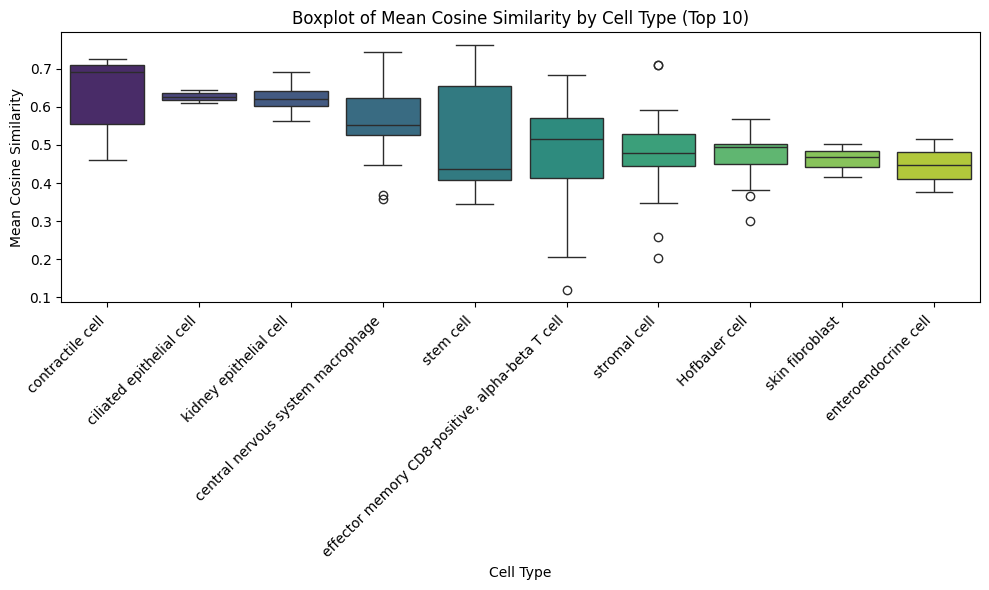

In [61]:
results = []
for cell_type, gene_data in cosine_similarities_by_cell_type.items():
    for gene, (mean_similarity, count) in gene_data.items():
        results.append({'cell_type': cell_type, 'gene': gene, 'mean_similarity': mean_similarity, 'count': count})

# Step 2: Create a DataFrame from the results
df = pd.DataFrame(results)

# Step 3: Calculate mean and 95% CI for each cell type
mean_ci = df.groupby('cell_type')['mean_similarity'].agg(
    mean_cosine_similarity='mean',
    count='count',
    std='std'
).reset_index()

# Step 4: Calculate the 95% CI
mean_ci['ci_lower'] = mean_ci['mean_cosine_similarity'] - 1.96 * (mean_ci['std'] / np.sqrt(mean_ci['count']))
mean_ci['ci_upper'] = mean_ci['mean_cosine_similarity'] + 1.96 * (mean_ci['std'] / np.sqrt(mean_ci['count']))

# Step 5: Sort by mean cosine similarity and get the top 10
top_10 = mean_ci.sort_values(by='mean_cosine_similarity', ascending=False).head(10)

# Step 6: Create a boxplot for the top 10 cell types
plt.figure(figsize=(10, 6))

# Filter the original DataFrame to include only the top 10 cell types
top_10_cell_types = top_10['cell_type'].tolist()
top_10_data = df[df['cell_type'].isin(top_10_cell_types)]

# Create the boxplot, ensuring the order is from highest to lowest
ax = sns.boxplot(data=top_10_data, x='cell_type', y='mean_similarity', 
            order=top_10_cell_types, palette='viridis')

plt.title('Boxplot of Mean Cosine Similarity by Cell Type (Top 10)')
plt.xlabel('Cell Type')
plt.ylabel('Mean Cosine Similarity')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust x-axis labels to stick closer to their boxes
plt.gca().tick_params(axis='x', pad=5)  # Adjust label position if necessary

plt.tight_layout()
plt.show()

/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/2320378652.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=top_10_data, x='cell_type', y='mean_similarity',
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/2320378652.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


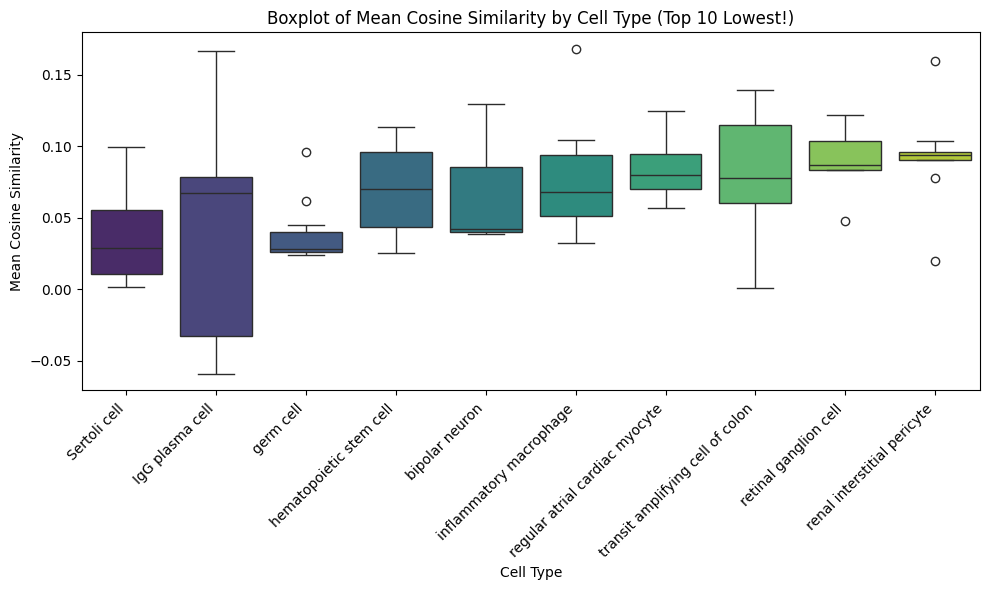

In [62]:
top_10 = mean_ci.sort_values(by='mean_cosine_similarity', ascending=True).head(10)

# Step 6: Create a boxplot for the top 10 cell types
plt.figure(figsize=(10, 6))

# Filter the original DataFrame to include only the top 10 cell types
top_10_cell_types = top_10['cell_type'].tolist()
top_10_data = df[df['cell_type'].isin(top_10_cell_types)]

# Create the boxplot, ensuring the order is from highest to lowest
ax = sns.boxplot(data=top_10_data, x='cell_type', y='mean_similarity', 
            order=top_10_cell_types, palette='viridis')

plt.title('Boxplot of Mean Cosine Similarity by Cell Type (Top 10 Lowest!)')
plt.xlabel('Cell Type')
plt.ylabel('Mean Cosine Similarity')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust x-axis labels to stick closer to their boxes
plt.gca().tick_params(axis='x', pad=5)  # Adjust label position if necessary

plt.tight_layout()
plt.show()

### for specific tissue

In [20]:
# Initialize a dictionary to store the cosine similarity values for each gene and Tissue
cosine_similarities_by_tissue = {}

# Retrieve age embeddings from 'tissue_embeddings'
age_embeddings = adata.obsm['tissue_embeddings']

# Loop through each unique Tissue in the dataset
for tissue in adata.obs['tissue'].unique():
    # Initialize a dictionary for this Tissue to store cosine similarities by gene
    cosine_similarities_by_tissue[tissue] = {}

    # Create a mask to select only cells of this particular Tissue
    tissue_mask = (adata.obs['tissue'] == tissue)
    
    # Loop through each gene embedding in obsm
    for gene_key in adata.obsm.keys():
        # Check if the key is for a gene embedding, and skip other embeddings
        if '_embeddings' in gene_key and gene_key not in ['development_stage_embeddings', 'tissue_embeddings', "cell_type_embeddings"]:
            gene_name = gene_key.replace('_embeddings', '')  # Get the actual gene name

            # Get the gene embeddings
            gene_embeddings = adata.obsm[gene_key]

            # Filter valid cells by gene embedding status, disease being 'normal', and the current Tissue
            valid_mask = (adata.obs[f'{gene_name}_embedding_status'] == 'present') & \
                         (adata.obs["disease"] == "normal") & tissue_mask

            # Select only valid gene embeddings and corresponding age embeddings
            valid_gene_embeddings = gene_embeddings[valid_mask]
            valid_age_embeddings = age_embeddings[valid_mask]

            # Proceed only if there are valid cells for this gene in the current Tissue
            if len(valid_gene_embeddings) != 0:
                # Compute cosine similarity between the valid gene and age embeddings
                cosine_sim = cosine_similarity(valid_gene_embeddings, valid_age_embeddings)

                # Take the diagonal since we are comparing cell i's gene embedding to cell i's age embedding
                diagonal_cosine_sim = np.diag(cosine_sim)

                # Store the mean cosine similarity and the number of valid comparisons for this gene and Tissue
                cosine_similarities_by_tissue[tissue][gene_name] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

for tissue, gene_similarities in cosine_similarities_by_tissue.items():
    # Sort the genes by mean cosine similarity in descending order
    sorted_genes = sorted(gene_similarities.items(), key=lambda x: x[1][1], reverse=True)

    print(f"Top 10 Genes for Tissue: {tissue}")
    # Print the top 10 genes for this Tissue
    for i, (gene, (values, mean_similarity, count)) in enumerate(sorted_genes[:10]):
        print(f"  {i+1}. Gene: {gene}, Mean Cosine Similarity: {mean_similarity}, Number of Cells: {count}")
    print()  # Newline for readability

Top 10 Genes for Tissue: cerebral nuclei
  1. Gene: CNTN1, Mean Cosine Similarity: 0.25681087374687195, Number of Cells: 187
  2. Gene: RBP2, Mean Cosine Similarity: 0.2462657243013382, Number of Cells: 10
  3. Gene: RARRES1, Mean Cosine Similarity: 0.24218988418579102, Number of Cells: 66
  4. Gene: PYY, Mean Cosine Similarity: 0.23133403062820435, Number of Cells: 11
  5. Gene: PRKN, Mean Cosine Similarity: 0.227803036570549, Number of Cells: 187
  6. Gene: IMMP2L, Mean Cosine Similarity: 0.21958842873573303, Number of Cells: 185
  7. Gene: RASGEF1B, Mean Cosine Similarity: 0.21927210688591003, Number of Cells: 118
  8. Gene: SLC26A3, Mean Cosine Similarity: 0.21392610669136047, Number of Cells: 15
  9. Gene: SCGB3A1, Mean Cosine Similarity: 0.21303308010101318, Number of Cells: 4
  10. Gene: RPL17P50, Mean Cosine Similarity: 0.20915941894054413, Number of Cells: 10

Top 10 Genes for Tissue: blood
  1. Gene: IGKV1D-33, Mean Cosine Similarity: 0.34333744645118713, Number of Cells: 2
 

In [21]:
data_dict = cosine_similarities_by_tissue

# Directory to save plots
output_dir = 'plots/top_genes_boxplots_tissue'
os.makedirs(output_dir, exist_ok=True)

# Plot and save the top 10 genes for each Tissue
for tissue, gene_data in data_dict.items():

    if gene_data != {}:
        # Sort the genes by their mean values and select the top 10
        sorted_genes = sorted(gene_data.items(), key=lambda x: x[1][1], reverse=True)[:10]
        
        # Extract the values for the top 10 genes
        gene_names = [gene for gene, _ in sorted_genes]
        values = [gene_data[gene][0] for gene, _ in sorted_genes]  # List of lists (each gene's values)
        
        # Prepare the data for the boxplot
        boxplot_data = []
        for gene_name, gene_values in zip(gene_names, values):
            for value in gene_values:
                boxplot_data.append({'Gene': gene_name, 'Expression': value})
        
        # Convert to DataFrame for Seaborn plotting
        import pandas as pd
        df = pd.DataFrame(boxplot_data)
        
        # Create the boxplot
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
        
        plt.title(f'Top 10 Genes for Tissue: {tissue}')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        
        # Save the plot
        plot_path = os.path.join(output_dir, f'{tissue.replace("-", "_").replace("/","_")}_top10_genes_boxplot.png')
        plt.savefig(plot_path)
        plt.close()  # Close the figure after saving to avoid display


/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/3513420275.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/3513420275.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2801/3513420275.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gene', y='Expression', palette='viridis')
/

In [45]:
mean_cosine_by_tissue = {}

# Loop through the cosine similarities for each Tissue
for tissue, gene_similarities in cosine_similarities_by_tissue.items():
    # Sort the genes by mean cosine similarity in descending order
    sorted_genes = sorted(gene_similarities.items(), key=lambda x: x[1][0], reverse=True)

    # Print the top 10 genes with the highest cosine similarity for this Tissue
    print(f"Top 10 Genes for Tissue: {tissue}")
    for i, (gene, (mean_similarity, count)) in enumerate(sorted_genes[:10]):
        print(f"  {i+1}. Gene: {gene}, Mean Cosine Similarity: {mean_similarity}, Number of Cells: {count}")
    print()  # Newline for readability
    
    # Calculate the overall mean cosine similarity for this Tissue
    overall_mean = np.mean([sim[0] for sim in gene_similarities.values()])
    mean_cosine_by_tissue[tissue] = overall_mean

# Find the Tissue with the highest and lowest mean cosine similarity
highest_tissue = max(mean_cosine_by_tissue, key=mean_cosine_by_tissue.get)
lowest_tissue = min(mean_cosine_by_tissue, key=mean_cosine_by_tissue.get)

# Print the most relevant Tissue based on age (highest mean cosine similarity)
print(f"The Tissue most relevant with age (highest mean cosine similarity): {highest_tissue} "
      f"with mean cosine similarity: {mean_cosine_by_tissue[highest_tissue]}")

# Print the least relevant Tissue based on age (lowest mean cosine similarity)
print(f"The Tissue least relevant with age (lowest mean cosine similarity): {lowest_tissue} "
      f"with mean cosine similarity: {mean_cosine_by_tissue[lowest_tissue]}")


Top 10 Genes for Tissue: cerebral nuclei
  1. Gene: CNTN1, Mean Cosine Similarity: 0.25681087374687195, Number of Cells: 187
  2. Gene: PRKN, Mean Cosine Similarity: 0.227803036570549, Number of Cells: 187
  3. Gene: IMMP2L, Mean Cosine Similarity: 0.21958842873573303, Number of Cells: 185
  4. Gene: CAMTA1, Mean Cosine Similarity: 0.20775212347507477, Number of Cells: 185
  5. Gene: MIR99AHG, Mean Cosine Similarity: 0.20619076490402222, Number of Cells: 176
  6. Gene: PLA2G6, Mean Cosine Similarity: 0.20287083089351654, Number of Cells: 26
  7. Gene: NAGK, Mean Cosine Similarity: 0.19754749536514282, Number of Cells: 43
  8. Gene: KCNH7, Mean Cosine Similarity: 0.1964263767004013, Number of Cells: 159
  9. Gene: RBX1, Mean Cosine Similarity: 0.18973025679588318, Number of Cells: 112
  10. Gene: COX7A2, Mean Cosine Similarity: 0.1875356137752533, Number of Cells: 82

Top 10 Genes for Tissue: blood
  1. Gene: IGKV1D-33, Mean Cosine Similarity: 0.34333744645118713, Number of Cells: 2
  2

/Users/yufanxia/Documents/GitHub/perturbgene/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yufanxia/Documents/GitHub/perturbgene/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [46]:
filtered_means = {tissue: mean for tissue, mean in mean_cosine_by_tissue.items() if not np.isnan(mean)}

# Calculate the top 3 highest and lowest mean cosine similarities
sorted_means = sorted(filtered_means.items(), key=lambda x: x[1])

# Top 3 lowest
top_3_lowest = sorted_means[:3]
# Top 3 highest
top_3_highest = sorted_means[-3:]

# Print the results
print("Top 3 Highest Mean Cosine Similarities:")
for i, (tissue, mean_similarity) in enumerate(reversed(top_3_highest), start=1):
    print(f"  {i}. Tissue: {tissue}, Mean Cosine Similarity: {mean_similarity}")

print("\nTop 3 Lowest Mean Cosine Similarities:")
for i, (tissue, mean_similarity) in enumerate(top_3_lowest, start=1):
    print(f"  {i}. Tissue: {tissue}, Mean Cosine Similarity: {mean_similarity}")

Top 3 Highest Mean Cosine Similarities:
  1. Tissue: adrenal gland, Mean Cosine Similarity: 0.6074047168046154
  2. Tissue: parietal lobe, Mean Cosine Similarity: 0.5655430555343628
  3. Tissue: prefrontal cortex, Mean Cosine Similarity: 0.5418058913247857

Top 3 Lowest Mean Cosine Similarities:
  1. Tissue: left cardiac atrium, Mean Cosine Similarity: 0.06052647903561592
  2. Tissue: skin of leg, Mean Cosine Similarity: 0.06304411590099335
  3. Tissue: respiratory airway, Mean Cosine Similarity: 0.06609799883695387


/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/3145238274.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=top_10_data, x='tissue', y='mean_similarity',
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/3145238274.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


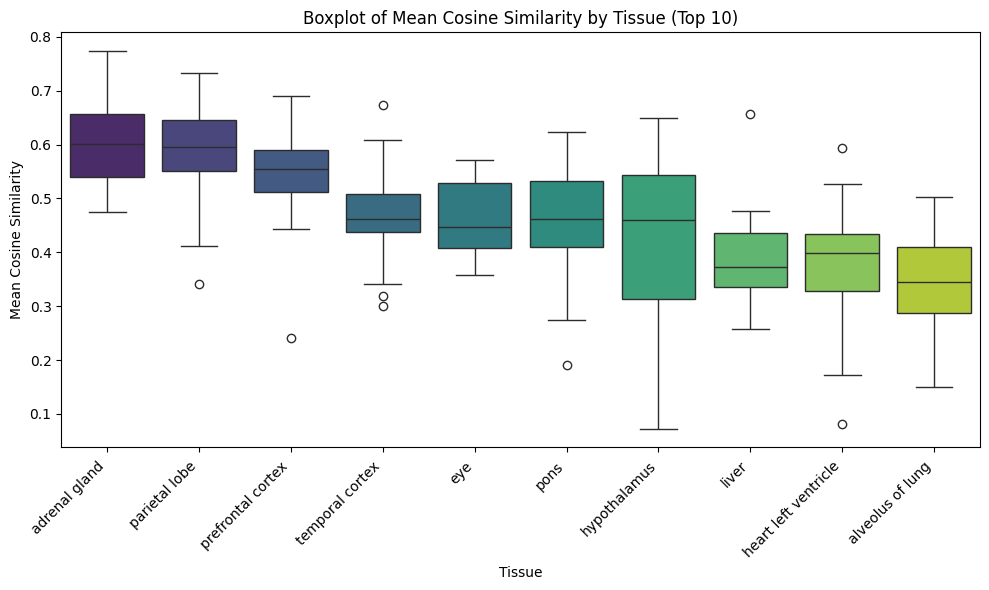

In [64]:
results = []
for tissue, gene_data in cosine_similarities_by_tissue.items():
    for gene, (mean_similarity, count) in gene_data.items():
        results.append({'tissue': tissue, 'gene': gene, 'mean_similarity': mean_similarity, 'count': count})

# Step 2: Create a DataFrame from the results
df = pd.DataFrame(results)

# Step 3: Calculate mean and 95% CI for each Tissue
mean_ci = df.groupby('tissue')['mean_similarity'].agg(
    mean_cosine_similarity='mean',
    count='count',
    std='std'
).reset_index()

# Step 4: Calculate the 95% CI
mean_ci['ci_lower'] = mean_ci['mean_cosine_similarity'] - 1.96 * (mean_ci['std'] / np.sqrt(mean_ci['count']))
mean_ci['ci_upper'] = mean_ci['mean_cosine_similarity'] + 1.96 * (mean_ci['std'] / np.sqrt(mean_ci['count']))

# Step 5: Sort by mean cosine similarity and get the top 10
top_10 = mean_ci.sort_values(by='mean_cosine_similarity', ascending=False).head(10)

# Step 6: Create a boxplot for the top 10 Tissues
plt.figure(figsize=(10, 6))

# Filter the original DataFrame to include only the top 10 Tissues
top_10_tissues = top_10['tissue'].tolist()
top_10_data = df[df['tissue'].isin(top_10_tissues)]

# Create the boxplot, ensuring the order is from highest to lowest
ax = sns.boxplot(data=top_10_data, x='tissue', y='mean_similarity', 
            order=top_10_tissues, palette='viridis')

plt.title('Boxplot of Mean Cosine Similarity by Tissue (Top 10)')
plt.xlabel('Tissue')
plt.ylabel('Mean Cosine Similarity')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust x-axis labels to stick closer to their boxes
plt.gca().tick_params(axis='x', pad=5)  # Adjust label position if necessary

plt.tight_layout()
plt.show()

/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/4152084778.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=top_10_data, x='tissue', y='mean_similarity',
/var/folders/pz/x2v3y0f93k9d3nfx01z18ctr0000gn/T/ipykernel_2240/4152084778.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


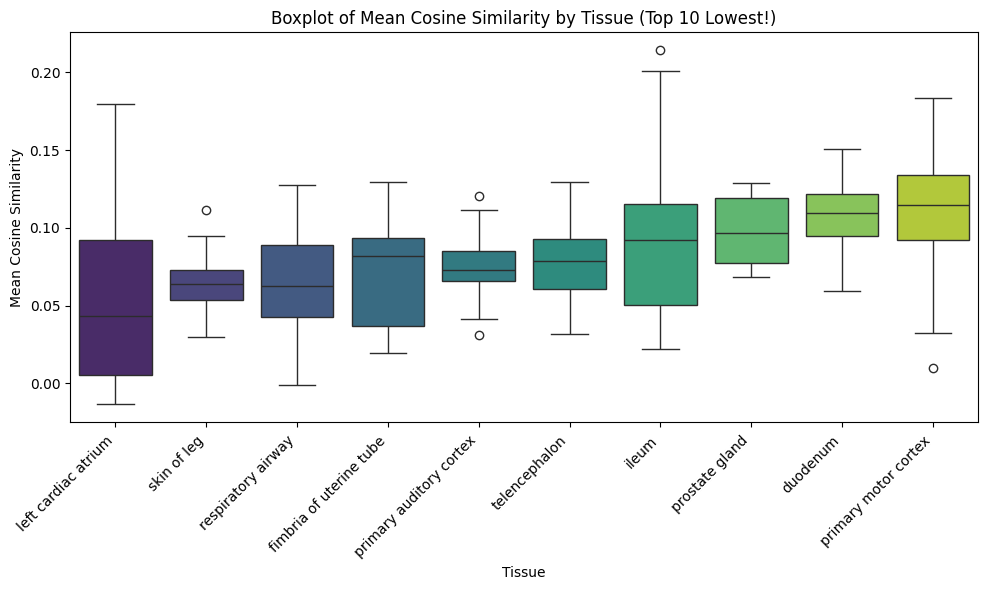

In [66]:
top_10 = mean_ci.sort_values(by='mean_cosine_similarity', ascending=True).head(10)

# Step 6: Create a boxplot for the top 10 Tissues
plt.figure(figsize=(10, 6))

# Filter the original DataFrame to include only the top 10 Tissues
top_10_tissues = top_10['tissue'].tolist()
top_10_data = df[df['tissue'].isin(top_10_tissues)]

# Create the boxplot, ensuring the order is from highest to lowest
ax = sns.boxplot(data=top_10_data, x='tissue', y='mean_similarity', 
            order=top_10_tissues, palette='viridis')

plt.title('Boxplot of Mean Cosine Similarity by Tissue (Top 10 Lowest!)')
plt.xlabel('Tissue')
plt.ylabel('Mean Cosine Similarity')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust x-axis labels to stick closer to their boxes
plt.gca().tick_params(axis='x', pad=5)  # Adjust label position if necessary

plt.tight_layout()
plt.show()

### for tissue-age sim

In [23]:
tissue_embeddings = adata.obsm['tissue_embeddings']
age_embeddings = adata.obsm["development_stage_embeddings"]

# Initialize a dictionary to store the cosine similarity values for each tissue
tissue_cosine_similarities = {}

# Grouping by tissue
for tissue in adata.obs['tissue'].unique():
    # Get the mask for the current tissue
    tissue_mask = adata.obs['tissue'] == tissue
    
    # Select valid tissue embeddings and corresponding age embeddings
    valid_tissue_embeddings = tissue_embeddings[tissue_mask]
    valid_age_embeddings = age_embeddings[tissue_mask]

    # Ensure there are valid embeddings to compute similarity
    if len(valid_tissue_embeddings) > 0:
        # Compute cosine similarity
        cosine_sim = cosine_similarity(valid_tissue_embeddings, valid_age_embeddings)

        # Take the diagonal since we are comparing cell i's tissue embedding to cell i's age embedding
        diagonal_cosine_sim = np.diag(cosine_sim)

        # Store the mean cosine similarity for this tissue
        tissue_cosine_similarities[tissue] = [np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

# Print out the results
for tissue, (mean_similarity, count) in tissue_cosine_similarities.items():
    print(f"Mean Cosine Similarity of tissue {tissue} is {mean_similarity} with {count} valid cells")

# Calculate the top 3 highest and lowest mean cosine similarities
sorted_tissues = sorted(tissue_cosine_similarities.items(), key=lambda x: x[1][0])

top_3_lowest = sorted_tissues[:3]
top_3_highest = sorted_tissues[-3:]

# Print the top 3 most relevant tissues
print("\nTop 3 Most Relevant Tissues:")
for i, (tissue, (mean_similarity, count)) in enumerate(reversed(top_3_highest), start=1):
    print(f"  {i}. Tissue: {tissue}, Mean Cosine Similarity: {mean_similarity}")

# Print the top 3 least relevant tissues
print("\nTop 3 Least Relevant Tissues:")
for i, (tissue, (mean_similarity, count)) in enumerate(top_3_lowest, start=1):
    print(f"  {i}. Tissue: {tissue}, Mean Cosine Similarity: {mean_similarity}")

Mean Cosine Similarity of tissue cerebral nuclei is 0.4450486898422241 with 187 valid cells
Mean Cosine Similarity of tissue blood is 0.43723371624946594 with 2292 valid cells
Mean Cosine Similarity of tissue thymus is 0.5092239379882812 with 166 valid cells
Mean Cosine Similarity of tissue spleen is 0.7129416465759277 with 119 valid cells
Mean Cosine Similarity of tissue transition zone of prostate is 0.4684695899486542 with 59 valid cells
Mean Cosine Similarity of tissue prefrontal cortex is 0.5738388299942017 with 20 valid cells
Mean Cosine Similarity of tissue lamina propria of mucosa of colon is 0.4865795075893402 with 40 valid cells
Mean Cosine Similarity of tissue lung is 0.5227632522583008 with 870 valid cells
Mean Cosine Similarity of tissue gonad is 0.45736896991729736 with 101 valid cells
Mean Cosine Similarity of tissue esophagus muscularis mucosa is 0.4434686005115509 with 49 valid cells
Mean Cosine Similarity of tissue cerebellum is 0.4058355987071991 with 501 valid cells

In [25]:
tissue_embeddings = adata.obsm['tissue_embeddings']
age_embeddings = adata.obsm["development_stage_embeddings"]

# Initialize a dictionary to store the cosine similarity values for each tissue
tissue_cosine_similarities = {}

# Grouping by tissue
for tissue in adata.obs['tissue'].unique():
    # Get the mask for the current tissue
    tissue_mask = (adata.obs['tissue'] == tissue) & (adata.obs["disease"] == "normal")
    
    # Select valid tissue embeddings and corresponding age embeddings
    valid_tissue_embeddings = tissue_embeddings[tissue_mask]
    valid_age_embeddings = age_embeddings[tissue_mask]

    # Ensure there are valid embeddings to compute similarity
    if len(valid_tissue_embeddings) > 0:
        # Compute cosine similarity
        cosine_sim = cosine_similarity(valid_tissue_embeddings, valid_age_embeddings)

        # Take the diagonal since we are comparing cell i's tissue embedding to cell i's age embedding
        diagonal_cosine_sim = np.diag(cosine_sim)

        # Store the mean cosine similarity for this tissue
        tissue_cosine_similarities[tissue] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

for tissue, (values, mean_similarity, count) in tissue_cosine_similarities.items():
    print(f"Mean Cosine Similarity of tissue {tissue} is {mean_similarity} with {count} valid cells")

# Calculate the top 3 highest and lowest mean cosine similarities
sorted_tissues = sorted(tissue_cosine_similarities.items(), key=lambda x: x[1][1])

top_3_lowest = sorted_tissues[:3]
top_3_highest = sorted_tissues[-3:]

# Print the top 3 most relevant tissues
print("\nTop 3 Most Relevant tissues:")
for i, (tissue, (values, mean_similarity, count)) in enumerate(reversed(top_3_highest), start=1):
    print(f"  {i}. tissue: {tissue}, Mean Cosine Similarity: {mean_similarity}")

# Print the top 3 least relevant tissues
print("\nTop 3 Least Relevant tissues:")
for i, (tissue, (values, mean_similarity, count)) in enumerate(top_3_lowest, start=1):
    print(f"  {i}. tissue: {tissue}, Mean Cosine Similarity: {mean_similarity}")

Mean Cosine Similarity of tissue cerebral nuclei is 0.4450486898422241 with 187 valid cells
Mean Cosine Similarity of tissue blood is 0.42493370175361633 with 769 valid cells
Mean Cosine Similarity of tissue thymus is 0.5092239379882812 with 166 valid cells
Mean Cosine Similarity of tissue spleen is 0.7129416465759277 with 119 valid cells
Mean Cosine Similarity of tissue prefrontal cortex is 0.5738388299942017 with 20 valid cells
Mean Cosine Similarity of tissue lung is 0.5432162284851074 with 451 valid cells
Mean Cosine Similarity of tissue gonad is 0.45736896991729736 with 101 valid cells
Mean Cosine Similarity of tissue esophagus muscularis mucosa is 0.4434686005115509 with 49 valid cells
Mean Cosine Similarity of tissue cerebellum is 0.4058355987071991 with 501 valid cells
Mean Cosine Similarity of tissue dorsolateral prefrontal cortex is 0.43848419189453125 with 291 valid cells
Mean Cosine Similarity of tissue alveolus of lung is 0.5703306794166565 with 39 valid cells
Mean Cosine 

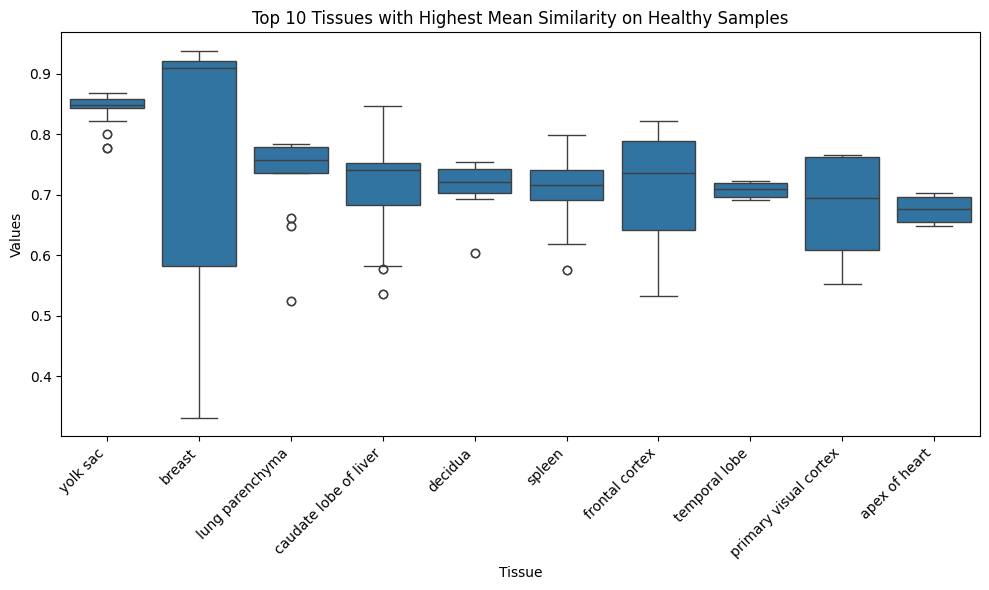

In [29]:
sorted_data = sorted(tissue_cosine_similarities.items(), key=lambda x: x[1][1], reverse=True)[:10]

# Step 2: Prepare data for plotting
plot_data = {
    'Tissue': [],
    'Values': []
}

for tissue, (values, mean_similarity, count) in sorted_data:
    plot_data['Tissue'].extend([tissue] * len(values))
    plot_data['Values'].extend(values)

# Convert to DataFrame for seaborn
df = pd.DataFrame(plot_data)

# Step 3: Create violin plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Tissue', y='Values', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Tissues with Highest Mean Similarity on Healthy Samples')
plt.tight_layout()

# Show the plot
plt.show()

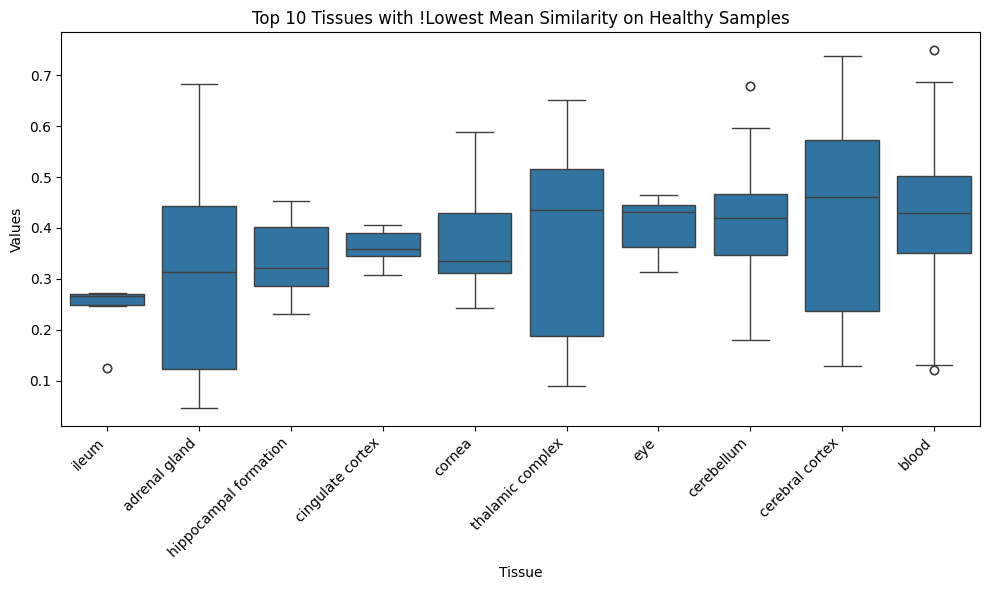

In [31]:
sorted_data = sorted(tissue_cosine_similarities.items(), key=lambda x: x[1][1])[:10]

# Step 2: Prepare data for plotting
plot_data = {
    'Tissue': [],
    'Values': []
}

for tissue, (values, mean_similarity, count) in sorted_data:
    plot_data['Tissue'].extend([tissue] * len(values))
    plot_data['Values'].extend(values)

# Convert to DataFrame for seaborn
df = pd.DataFrame(plot_data)

# Step 3: Create violin plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Tissue', y='Values', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Tissues with !Lowest Mean Similarity on Healthy Samples')
plt.tight_layout()

# Show the plot
plt.show()

### for cell_type-age 

In [3]:
cell_type_embeddings = adata.obsm['cell_type_embeddings']
age_embeddings = adata.obsm["development_stage_embeddings"]

# Initialize a dictionary to store the cosine similarity values for each cell_type
cell_type_cosine_similarities = {}

# Grouping by cell_type
for cell_type in adata.obs['cell_type'].unique():
    # Get the mask for the current cell_type
    cell_type_mask = adata.obs['cell_type'] == cell_type
    
    # Select valid cell_type embeddings and corresponding age embeddings
    valid_cell_type_embeddings = cell_type_embeddings[cell_type_mask]
    valid_age_embeddings = age_embeddings[cell_type_mask]

    # Ensure there are valid embeddings to compute similarity
    if len(valid_cell_type_embeddings) > 0:
        # Compute cosine similarity
        cosine_sim = cosine_similarity(valid_cell_type_embeddings, valid_age_embeddings)

        # Take the diagonal since we are comparing cell i's cell_type embedding to cell i's age embedding
        diagonal_cosine_sim = np.diag(cosine_sim)

        # Store the mean cosine similarity for this cell_type
        cell_type_cosine_similarities[cell_type] = [np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

# Print out the results
for cell_type, (mean_similarity, count) in cell_type_cosine_similarities.items():
    print(f"Mean Cosine Similarity of cell_type {cell_type} is {mean_similarity} with {count} valid cells")

# Calculate the top 3 highest and lowest mean cosine similarities
sorted_cell_types = sorted(cell_type_cosine_similarities.items(), key=lambda x: x[1][0])

top_3_lowest = sorted_cell_types[:3]
top_3_highest = sorted_cell_types[-3:]

# Print the top 3 most relevant cell_types
print("\nTop 3 Most Relevant Cell Types:")
for i, (cell_type, (mean_similarity, count)) in enumerate(reversed(top_3_highest), start=1):
    print(f"  {i}. Cell Type: {cell_type}, Mean Cosine Similarity: {mean_similarity}")

# Print the top 3 least relevant cell_types
print("\nTop 3 Least Relevant Cell_Types:")
for i, (cell_type, (mean_similarity, count)) in enumerate(top_3_lowest, start=1):
    print(f"  {i}. Cell Type: {cell_type}, Mean Cosine Similarity: {mean_similarity}")

Mean Cosine Similarity of cell_type neuron is 0.39169228076934814 with 665 valid cells
Mean Cosine Similarity of cell_type classical monocyte is 0.4203423857688904 with 245 valid cells
Mean Cosine Similarity of cell_type CD8-positive, alpha-beta T cell is 0.3080242872238159 with 341 valid cells
Mean Cosine Similarity of cell_type common lymphoid progenitor is 0.5613232851028442 with 26 valid cells
Mean Cosine Similarity of cell_type double-positive, alpha-beta thymocyte is 0.3993591368198395 with 81 valid cells
Mean Cosine Similarity of cell_type CD4-positive, alpha-beta T cell is 0.3084132671356201 with 368 valid cells
Mean Cosine Similarity of cell_type CD4-positive, alpha-beta thymocyte is 0.5688491463661194 with 13 valid cells
Mean Cosine Similarity of cell_type mature alpha-beta T cell is 0.337250292301178 with 77 valid cells
Mean Cosine Similarity of cell_type glutamatergic neuron is 0.4181326627731323 with 307 valid cells
Mean Cosine Similarity of cell_type fibroblast is 0.62597

In [15]:
cell_type_embeddings = adata.obsm['cell_type_embeddings']
age_embeddings = adata.obsm["development_stage_embeddings"]

# Initialize a dictionary to store the cosine similarity values for each cell_type
cell_type_cosine_similarities = {}

# Grouping by cell_type
for cell_type in adata.obs['cell_type'].unique():
    # Get the mask for the current cell_type
    cell_type_mask = (adata.obs['cell_type'] == cell_type) & (adata.obs["disease"] == "normal")
    
    # Select valid cell_type embeddings and corresponding age embeddings
    valid_cell_type_embeddings = cell_type_embeddings[cell_type_mask]
    valid_age_embeddings = age_embeddings[cell_type_mask]

    # Ensure there are valid embeddings to compute similarity
    if len(valid_cell_type_embeddings) > 0:
        # Compute cosine similarity
        cosine_sim = cosine_similarity(valid_cell_type_embeddings, valid_age_embeddings)

        # Take the diagonal since we are comparing cell i's cell_type embedding to cell i's age embedding
        diagonal_cosine_sim = np.diag(cosine_sim)

        # Store the mean cosine similarity for this cell_type
        cell_type_cosine_similarities[cell_type] = [diagonal_cosine_sim, np.mean(diagonal_cosine_sim), len(diagonal_cosine_sim)]

# Print out the results
for cell_type, (values, mean_similarity, count) in cell_type_cosine_similarities.items():
    print(f"Mean Cosine Similarity of cell_type {cell_type} is {mean_similarity} with {count} valid cells")

# Calculate the top 3 highest and lowest mean cosine similarities
sorted_cell_types = sorted(cell_type_cosine_similarities.items(), key=lambda x: x[1][1])

top_3_lowest = sorted_cell_types[:3]
top_3_highest = sorted_cell_types[-3:]

# Print the top 3 most relevant cell_types
print("\nTop 3 Most Relevant cell_types:")
for i, (cell_type, (values, mean_similarity, count)) in enumerate(reversed(top_3_highest), start=1):
    print(f"  {i}. cell_type: {cell_type}, Mean Cosine Similarity: {mean_similarity}")

# Print the top 3 least relevant cell_types
print("\nTop 3 Least Relevant cell_types:")
for i, (cell_type, (values, mean_similarity, count)) in enumerate(top_3_lowest, start=1):
    print(f"  {i}. cell_type: {cell_type}, Mean Cosine Similarity: {mean_similarity}")

Mean Cosine Similarity of cell_type neuron is 0.39169228076934814 with 665 valid cells
Mean Cosine Similarity of cell_type classical monocyte is 0.45730331540107727 with 56 valid cells
Mean Cosine Similarity of cell_type CD8-positive, alpha-beta T cell is 0.28655195236206055 with 97 valid cells
Mean Cosine Similarity of cell_type double-positive, alpha-beta thymocyte is 0.3993591368198395 with 81 valid cells
Mean Cosine Similarity of cell_type CD4-positive, alpha-beta T cell is 0.31403157114982605 with 125 valid cells
Mean Cosine Similarity of cell_type mature alpha-beta T cell is 0.337406724691391 with 23 valid cells
Mean Cosine Similarity of cell_type glutamatergic neuron is 0.4181326627731323 with 307 valid cells
Mean Cosine Similarity of cell_type fibroblast is 0.6400875449180603 with 175 valid cells
Mean Cosine Similarity of cell_type alveolar macrophage is 0.571107029914856 with 45 valid cells
Mean Cosine Similarity of cell_type mesothelial cell is 0.47333914041519165 with 18 val

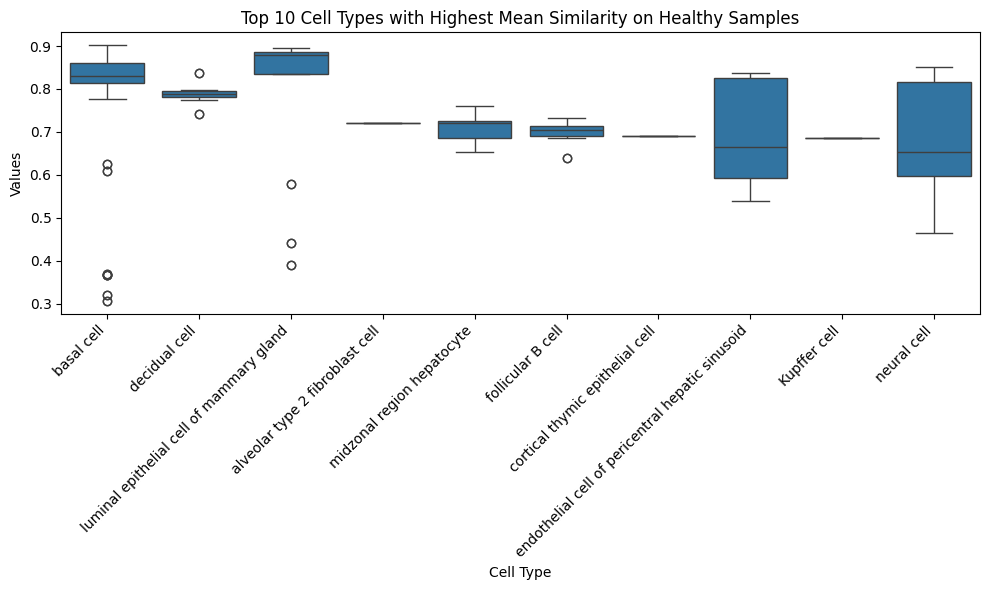

In [32]:
sorted_data = sorted(cell_type_cosine_similarities.items(), key=lambda x: x[1][1], reverse=True)[:10]

# Step 2: Prepare data for plotting
plot_data = {
    'Cell Type': [],
    'Values': []
}

for cell_type, (values, mean_similarity, count) in sorted_data:
    plot_data['Cell Type'].extend([cell_type] * len(values))
    plot_data['Values'].extend(values)

# Convert to DataFrame for seaborn
df = pd.DataFrame(plot_data)

# Step 3: Create violin plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cell Type', y='Values', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Cell Types with Highest Mean Similarity on Healthy Samples')
plt.tight_layout()

# Show the plot
plt.show()

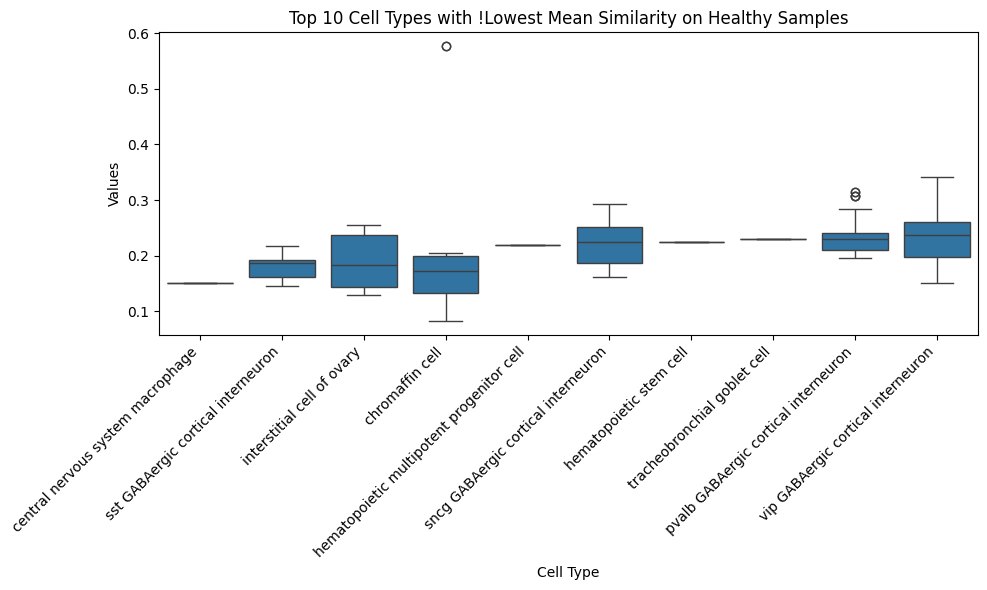

In [33]:
sorted_data = sorted(cell_type_cosine_similarities.items(), key=lambda x: x[1][1])[:10]

# Step 2: Prepare data for plotting
plot_data = {
    'Cell Type': [],
    'Values': []
}

for cell_type, (values, mean_similarity, count) in sorted_data:
    plot_data['Cell Type'].extend([cell_type] * len(values))
    plot_data['Values'].extend(values)

# Convert to DataFrame for seaborn
df = pd.DataFrame(plot_data)

# Step 3: Create violin plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cell Type', y='Values', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Cell Types with !Lowest Mean Similarity on Healthy Samples')
plt.tight_layout()

# Show the plot
plt.show()